In [493]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import sklearn
from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import confusion_matrix, precision_score, precision_recall_curve, recall_score, f1_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import accuracy_score
import eli5
from imblearn.over_sampling import SMOTE 
from os import path
from wordcloud import WordCloud, STOPWORDS 
from PIL import Image
from wordcloud import ImageColorGenerator
import re

import pickle
import joblib
import re
import nltk
from nltk.corpus import stopwords
#nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
import string
import numpy as np
#nltk.download('punkt')
from nltk import word_tokenize,sent_tokenize
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import datetime
import warnings
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from bs4 import BeautifulSoup
from gensim.models import CoherenceModel
from pyLDAvis import gensim

In [2]:
tweets = pd.read_csv("/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/Tweets2.csv")

In [3]:
tweets.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2/24/15 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2/24/15 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2/24/15 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2/24/15 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2/24/15 11:14,NaN,Pacific Time (US & Canada)


In [4]:
tweets.airline_sentiment.value_counts()/len(tweets)

negative    0.626913
neutral     0.211680
positive    0.161407
Name: airline_sentiment, dtype: float64

# EDA

In [5]:
split = np.random.rand(len(tweets)) <= 0.7
train = tweets[split]
test = tweets[~split]

print('train data size:', len(train))
print('test data size:', len(test))

train data size: 10217
test data size: 4423


In [6]:
train_data = []
test_data = []

for row in train.text:
    train_data.append(row)
    
for row in test.text:
    test_data.append(row)
    
print(len(train_data))
print(len(test_data))

10217
4423


In [7]:
color3 =['#f49c6c','#8cbcfb','#3f5994']

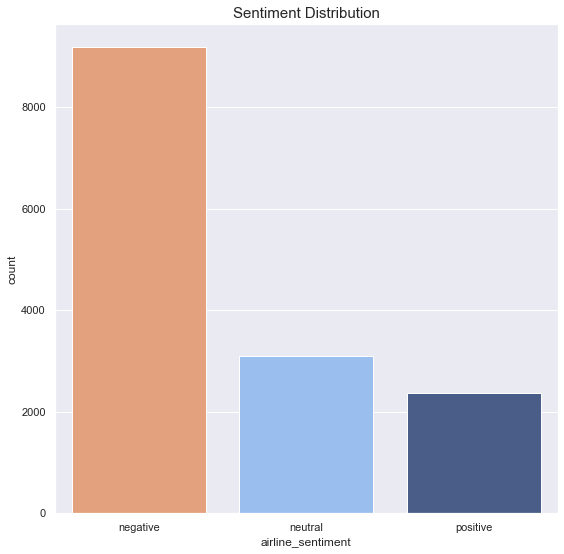

In [233]:
sns.set()
sns.set_style("darkgrid")
plt.figure(figsize=(9,9))
sns.countplot(x=tweets["airline_sentiment"],palette=color3,order=tweets["airline_sentiment"].value_counts().index)
plt.title("Sentiment Distribution",fontsize=15)
plt.show()

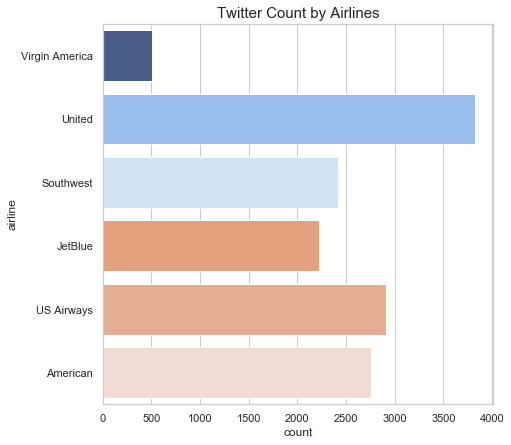

In [135]:
sns.set()
sns.set_style("whitegrid")
plt.figure(figsize=(7,7))
sns.countplot(y=tweets["airline"],palette=colors)
plt.title("Twitter Count by Airlines",fontsize=15)
plt.show()

In [51]:
df=tweets.groupby(['airline']).size().reset_index(name='counts')
df=df.sort_values(by=['counts'],ascending=False).reset_index(drop=True)
df

,airline,counts
0,United,3822
1,US Airways,2913
2,American,2759
3,Southwest,2420
4,JetBlue,2222
5,Virgin America,504


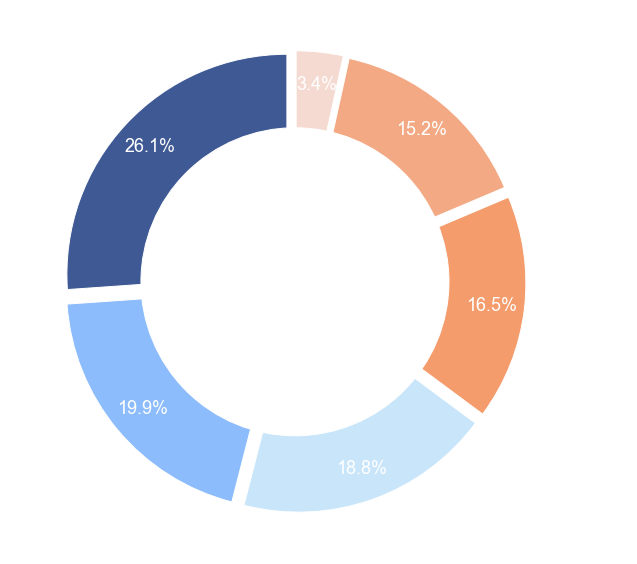

In [129]:
# Pie chart
labels = df.airline
sizes = df.counts
#colors
colors = ['#3f5994','#8cbcfb','#c9e5fa','#f49c6c', '#f3aa84','#f4dad0']
#explsion
explode = (0.05,0.05,0.05,0.05,0.05,0.05)

sns.set_style('whitegrid')
plt.figure(figsize=(9,9))
plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, explode = explode,\
        textprops={'fontsize': 18, 'color':"w"})
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
plt.tight_layout()
plt.show()
fig.savefig('/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/tweetsperairline.png',transparent=True)

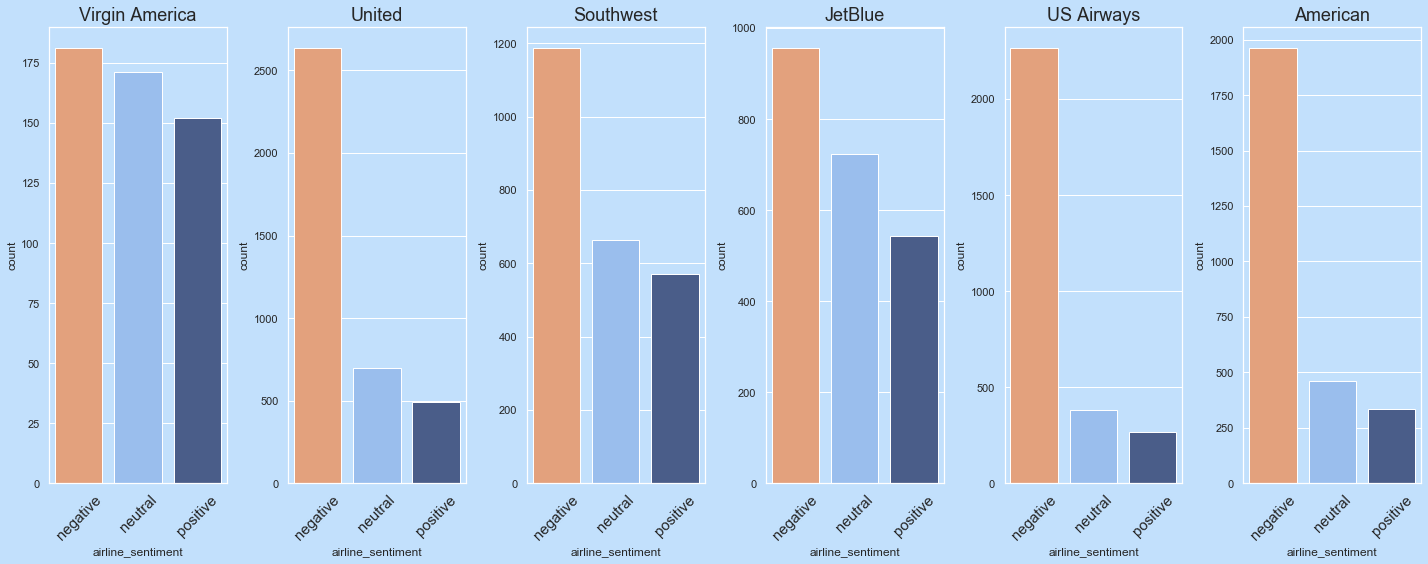

In [235]:
j=1
sns.set(rc={'axes.facecolor':'#c2e0fc', 'figure.facecolor':'#c2e0fc'})
plt.subplots(figsize=(20,8),tight_layout=True)
for i in tweets["airline"].unique():
        x = tweets[tweets["airline"]==i]
        plt.subplot(1, 6, j)
        sns.countplot(x["airline_sentiment"],palette=color3,
                     order=x['airline_sentiment'].value_counts().index)
        plt.xticks(rotation=45, fontsize=15)
        plt.title(i,fontsize=18)
        j +=1
plt.show()

### EDA for Custom Feature

In [7]:
#text length
word_count = []
for row in tweets.text.index:
    word_count.append(len([i for i in tweets.text[row].split(' ')]))

In [8]:
char_len = []
for row in tweets.text.index:
    char_len.append(len([i for i in tweets.text[row]]))

In [9]:
tag_cnt = []
for row in tweets.text.index:
    tag_cnt.append(len(re.findall(r'@',tweets.text[row])))

In [10]:
esclam_q_mark = []
for row in tweets.text.index:
    esclam_q_mark.append(len(re.findall(r'!|\?', tweets.text[row])))

In [11]:
cap = []
for row in tweets.text.index:
    cap.append(len(re.findall(r'\b[A-Z]{2,}\b', tweets.text[row])))

In [12]:
tweets['word_count']=word_count
tweets['char_len']=char_len
tweets['tag_cnt']=tag_cnt
tweets['esclam_q_mark']=esclam_q_mark
tweets['cap']=cap

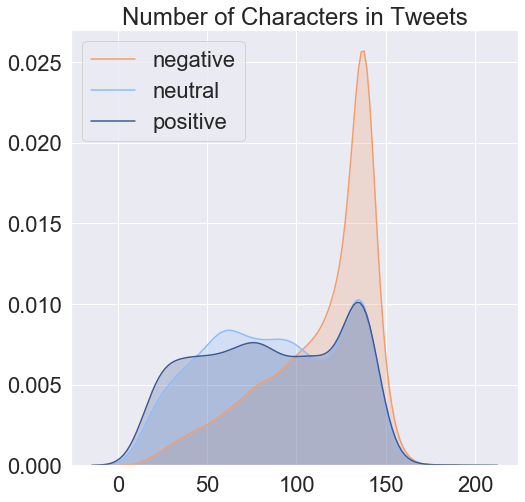

In [20]:
sns.set(style="darkgrid",font_scale=2)
snsplt = plt.figure(figsize=(8,8))
snsplt = plt.title('Number of Characters in Tweets')
snsplt=sns.kdeplot(tweets[tweets.airline_sentiment == 'negative']['char_len'], shade=True, color="#f49c6c",label='negative')
snsplt=sns.kdeplot(tweets[tweets.airline_sentiment == 'neutral']['char_len'], shade=True, color="#8cbcfb",label='neutral')
snsplt=sns.kdeplot(tweets[tweets.airline_sentiment == 'positive']['char_len'], shade=True, color="#3f5994",label='positive')
p=snsplt.get_figure()
p.savefig('/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/nchar.png',transparent=True)

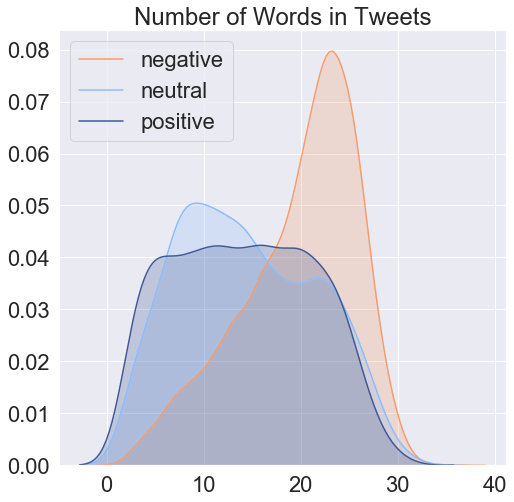

In [282]:
sns.set(style='darkgrid',font_scale=2)
snsplt = plt.figure(figsize=(8,8))
snsplt = plt.title('Number of Words in Tweets')
snsplt=sns.kdeplot(tweets[tweets.airline_sentiment == 'negative']['word_count'], shade=True, color="#f49c6c",label='negative')
snsplt=sns.kdeplot(tweets[tweets.airline_sentiment == 'neutral']['word_count'], shade=True, color="#8cbcfb",label='neutral')
snsplt=sns.kdeplot(tweets[tweets.airline_sentiment == 'positive']['word_count'], shade=True, color="#3f5994",label='positive')
p=snsplt.get_figure()
p.savefig('/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/wordcnt.png',transparent=True)

In [27]:
color4 =['#8cbcfb','#3f5994','#f49c6c']

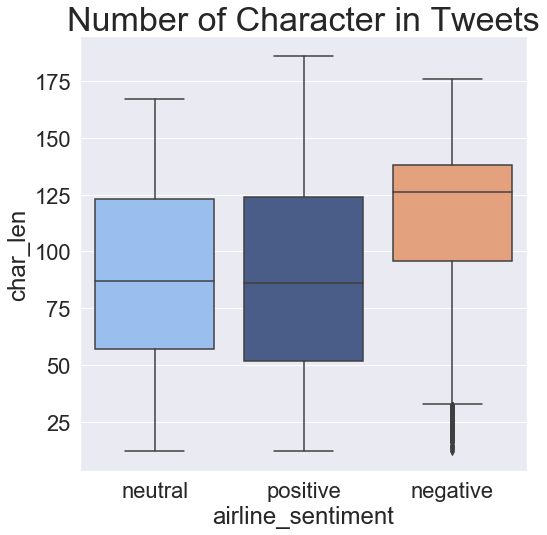

In [28]:
plt.figure(figsize=(8,8))
sns.set({'axes.facecolor':'white'},style="darkgrid",font_scale=2)
ax = sns.boxplot(y=tweets['char_len'],x=tweets['airline_sentiment'], palette=color4)
plt.title('Number of Character in Tweets',size=34)
a=ax.get_figure()
a.savefig('/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/ncharbox.png',transparent=True)
plt.show()

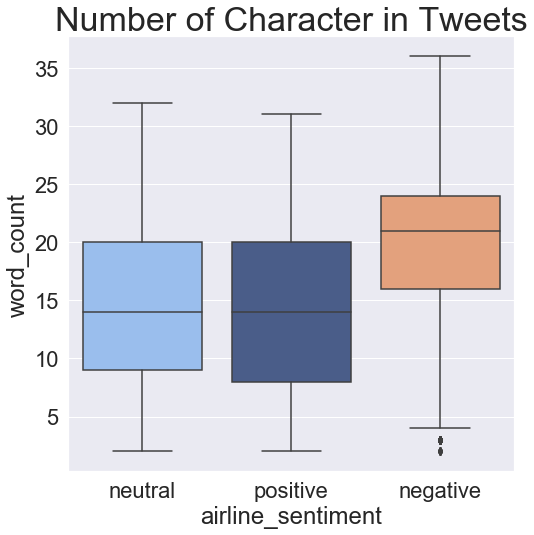

In [29]:
plt.figure(figsize=(8,8))
sns.set({'axes.facecolor':'white'},style="darkgrid",font_scale=2)
ax = sns.boxplot(y=tweets['word_count'],x=tweets['airline_sentiment'], palette=color4)
plt.title('Number of Character in Tweets',size=34)
a=ax.get_figure()
a.savefig('/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/wcbox.png',transparent=True)
plt.show()

### Anova for Char_length

In [17]:
from scipy import stats
F, p = stats.f_oneway(tweets[tweets.airline_sentiment == 'negative']['char_len'], 
                      tweets[tweets.airline_sentiment == 'positive']['char_len'], 
                      tweets[tweets.airline_sentiment == 'neutral']['char_len'])

print(stats.f_oneway(tweets[tweets.airline_sentiment == 'negative']['char_len'], 
                      tweets[tweets.airline_sentiment == 'positive']['char_len'], 
                      tweets[tweets.airline_sentiment == 'neutral']['char_len']))
print(F)
print(p)

F_onewayResult(statistic=1103.6098891384172, pvalue=0.0)
1103.6098891384172
0.0


In [14]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('char_len ~ airline_sentiment',
                data=tweets).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

                         sum_sq       df            F  PR(>F)
airline_sentiment  2.524509e+06      2.0  1103.609889     0.0
Residual           1.674108e+07  14637.0          NaN     NaN


### Anova for WordCount

In [18]:
from scipy import stats
F, p = stats.f_oneway(tweets[tweets.airline_sentiment == 'negative']['word_count'], 
                      tweets[tweets.airline_sentiment == 'positive']['word_count'], 
                      tweets[tweets.airline_sentiment == 'neutral']['word_count'])

print(stats.f_oneway(tweets[tweets.airline_sentiment == 'negative']['word_count'], 
                      tweets[tweets.airline_sentiment == 'positive']['word_count'], 
                      tweets[tweets.airline_sentiment == 'neutral']['word_count']))
print(F)
print(p)

F_onewayResult(statistic=1257.5131958155853, pvalue=0.0)
1257.5131958155853
0.0


# Multinomial Naive Bayes

### 1.Tuning Vectorizer and Parameters

In [392]:
##testing a custom vectorizer
lmtzr = WordNetLemmatizer()
r = re.compile(r'(?<=\@)(\w+)') #remove words after tags --> usually twitter account
ra = re.compile(r'(?<=\#)(\w+)') #remove words after hashtags
ro = re.compile(r'(flt\d*)') #remove words after flight number
names = r.findall(text.lower())
hashtag = ra.findall(text.lower())
flight = ro.findall(text.lower())
rem = ["american", "air","airline","thank","united","us","airways","virgin","america","jetblue",
         "usairway","usairways","flight","americanair","southwestair","southwestairlines",
         "southwestairway","southwestairways","virginamerica","really","will","going","thanks","thankyou",
         "please","got","let","take","help","already","never","now","told","guy","new","sure","still","amp",
         "plane","tell","ye","trying","yes","guy","much","appreciate", "thx","back","ok","good",
         "flying","love","great","awesome","see","nice","alway","httptcojwl26g6lrw","dontflythem",
         "nogearnotraining","seriously","didnt","coudnt","cant","wont","dont","wat","buffaloniagara",
         "woulda"]
def stem_tokens(tokens, lemmatize):
    lemmatized = []
    for item in tokens:
        lemmatized.append(lmtzr.lemmatize(item,'v'))
    return lemmatized
def tokenize(text):
    
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    text = deEmojify(text)
    soup = BeautifulSoup(text)
    text = soup.get_text()
    text = "".join([ch.lower() for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    tokens = [ch for ch in tokens if len(ch)>1]
    lemm = stem_tokens(tokens, lmtzr)
    lemm = [i for i in lemm if i not in rem]
    lemm = [i for i in lemm if i not in names]
    lemm = [i for i in lemm if i not in hashtag]
    lemm = [i for i in lemm if i not in flight]
    return lemm

default => (0.8388959577175296, 0.7594392945964278)
sub => (0.9908975237349515, 0.7583088401537418)
nosmooth => (0.9908975237349515, 0.7574044765995931)
3g => (0.8393853381618871, 0.7605697490391137)
vectoken => (0.783498091416267, 0.7044992086818901)
vec3gtoken => (0.78369384359401, 0.7033687542392042)
combinedtoken => (0.7795830478614074, 0.7083427537870224)
basictoken => (0.9691690320054811, 0.7017861180194438)


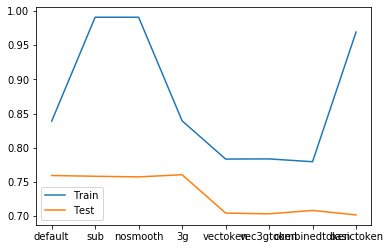

In [394]:
import warnings
warnings.simplefilter('ignore')

def classification(vectorizer, model, fit_vect=False):
    if fit_vect:
        vectorizer.fit(train.data)
    train.vecs = vectorizer.transform(train.text)
    test.vecs = vectorizer.transform(test.text)
    model.fit(train.vecs, train.airline_sentiment)
    train_preds = model.predict(train.vecs)
    train_f1 = f1_score(train.airline_sentiment, train_preds, average='micro')
    test_preds = model.predict(test.vecs)
    test_f1 = f1_score(test.airline_sentiment, test_preds, average='micro')
    return train_f1, test_f1  


tfidf_vectorizers = [TfidfVectorizer(min_df=5,max_df=0.7, lowercase=True,ngram_range=(1,2),stop_words='english'), 
                     TfidfVectorizer(sublinear_tf=True, lowercase=True, ngram_range=(1,2), stop_words='english'),
                     TfidfVectorizer(smooth_idf=False, lowercase=True, ngram_range=(1,2), stop_words='english'),
                     TfidfVectorizer(min_df=5,max_df=0.7, lowercase=True,ngram_range=(1,3),stop_words='english'),
                        #using bog
                     CountVectorizer(tokenizer=tokenize,min_df=5,max_df=0.7, lowercase=True,ngram_range=(1,2),stop_words='english'),
                     CountVectorizer(tokenizer=tokenize,min_df=5,max_df=0.7, lowercase=True,ngram_range=(1,3),stop_words='english'),
                         #based on best combination above, use the custom tokenizer
                     TfidfVectorizer(tokenizer=tokenize, min_df=5,max_df=0.7, lowercase=True,ngram_range=(1,3),stop_words='english'),
                     TfidfVectorizer(tokenizer=tokenize,ngram_range=(1,3), lowercase=True, stop_words='english')
                    ] 
names = ['default', 'sub', 'nosmooth','3g','vectoken', 'vec3gtoken','combinedtoken','basictoken'] 
xs = list(range(len(tfidf_vectorizers)))
results = list()
for i in range(len(tfidf_vectorizers)):
    tfidf_vectorizers[i].fit(train.text)
    model = MultinomialNB(alpha=0.009) # set a very small value
    res = classification(tfidf_vectorizers[i], model) # we need to set fit_vect=True
    results.append(res)
    print(names[i], '=>', res)

plt.plot(xs, results)
plt.xticks(xs, names)
plt.legend(["Train", "Test"])
plt.show()

### 2.Smote Resample on the Best Tuned Vectorizer

In [147]:
sm = SMOTE(random_state=777) 
tv = TfidfVectorizer(min_df=5,max_df=0.7,ngram_range=(1,3), lowercase=True, stop_words='english')
tv.fit(train.text)

X_train_res, y_train_res = sm.fit_sample(tv.transform(train.text.values),train.airline_sentiment)

In [148]:
MNBmodel = MultinomialNB(alpha=0.009)
MNBmodel.fit(X_train_res, y_train_res)

MultinomialNB(alpha=0.009, class_prior=None, fit_prior=True)

In [161]:
train_s_preds = MNBmodel.predict(X_train_res)
trains_f1 = f1_score(y_train_res, train_s_preds, average='micro')
test_s_preds = MNBmodel.predict(tv.transform(test.text))
tests_f1 = f1_score(test.airline_sentiment, test_s_preds, average='micro')

print("Train Confusion Matrix:\n", confusion_matrix(y_train_res, train_s_preds))
print("Train F1 score:", trains_f1)

print("Test Confusion Matrix:\n", confusion_matrix(test.airline_sentiment, test_s_preds))
print("Test F1 score:", tests_f1)

Train Confusion Matrix:
 [[5586  580  245]
 [ 595 5284  532]
 [ 178  294 5939]]
Train F1 score: 0.8739666198720948
Test Confusion Matrix:
 [[2302  337  128]
 [ 278  532  135]
 [ 125  122  467]]
Test F1 score: 0.745820153637596


### 3.Custom Feature Model with Best Tuned Vectorizer

In [168]:
def wordcnt(text):
    for row in text:
        words = row.split(' ')
    return len(words)

class CustomFeats(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.feat_names = set()
    
    def fit(self, x, y=None):
        return self

    @staticmethod
    def features(text):
        return {'char_len' : len(text),
                'wordcnt': wordcnt(text)}

    def get_feature_names(self):
        return list(self.feat_names)
      
    def transform(self, text):
        feats = []
        for t in text:
            f = self.features(text)
            [self.feat_names.add(k) for k in f] 
            feats.append(f)
        return feats
    
feats = FeatureUnion([
     ('custom', make_pipeline(CustomFeats(), DictVectorizer())),
     ('bag_of_words', TfidfVectorizer(min_df=5,max_df=0.7,ngram_range=(1,3), lowercase=True, stop_words='english'))])
feats    

FeatureUnion(n_jobs=None,
             transformer_list=[('custom',
                                Pipeline(memory=None,
                                         steps=[('customfeats', CustomFeats()),
                                                ('dictvectorizer',
                                                 DictVectorizer(dtype=<class 'numpy.float64'>,
                                                                separator='=',
                                                                sort=True,
                                                                sparse=True))],
                                         verbose=False)),
                               ('bag_of_words',
                                TfidfVectorizer(analyzer='word', binary=False,
                                                decode_error='strict',
                                                dtype=<class 'numpy.float64'>,
                                                encoding='utf-8',
 

In [169]:
mnb_model = make_pipeline(feats, MultinomialNB(alpha=0.009))
mnb_model.fit(train.text, train.airline_sentiment)

train_preds = mnb_model.predict(train.text)
train_f1 = f1_score(train.airline_sentiment, train_preds, average='micro')
test_preds = mnb_model.predict(test.text)
test_f1 = f1_score(test.airline_sentiment, test_preds, average='micro')
train_acc = accuracy_score(train.airline_sentiment, train_preds, normalize=False)
test_acc = accuracy_score(test.airline_sentiment, test_preds, normalize=False)

print("Train Confusion Matrix:\n", confusion_matrix(train.airline_sentiment, train_preds))
print("Train F1 score:", train_f1)
print("train accuracy :",train_acc/len(train)," ")

print("Test Confusion Matrix:\n", confusion_matrix(test.airline_sentiment, test_preds))
print("Test F1 score:", test_f1)
print("test accuracy :",test_acc/len(test))

Train Confusion Matrix:
 [[6138  189   84]
 [ 792 1247  115]
 [ 316  102 1231]]
Train F1 score: 0.843548071274721
train accuracy : 0.843548071274721  
Test Confusion Matrix:
 [[2648   88   31]
 [ 558  339   48]
 [ 275   73  366]]
Test F1 score: 0.7575689109805694
test accuracy : 0.7575689109805693


### 4.Tuning Bayes Parameter

In [216]:
tv1=TfidfVectorizer(min_df=5,max_df=0.7,ngram_range=(1,3), lowercase=True, stop_words='english')

a = np.linspace(0.0001,0.1,12)
b = np.linspace(0.2,1,9)
alpha = np.append(a,b)
mnb_modelt = []
train_preds = []
train_f1=[]
test_preds=[]
test_f1=[]
result = []

for i in range(len(alpha)):
    mnb_modelt.append(make_pipeline(tv1, MultinomialNB(alpha[i])))
    mnb_modelt[i].fit(train.text, train.airline_sentiment)
    train_preds.append(mnb_modelt[i].predict(train.text))
    train_f1.append(f1_score(train.airline_sentiment, train_preds[i], average='micro'))
    test_preds.append(mnb_modelt[i].predict(test.text))
    test_f1.append(f1_score(test.airline_sentiment, test_preds[i], average='micro'))
    result.append([train_f1[i],test_f1[i]])
    print("alpha =",round(alpha[i],5), "----->","train F1:",train_f1[i],"test F1:",test_f1[i])

alpha = 0.0001 -----> train F1: 0.8429606422557274 test F1: 0.7605061003163127
alpha = 0.00918 -----> train F1: 0.8420794987272371 test F1: 0.762765476728423
alpha = 0.01826 -----> train F1: 0.8414920697082436 test F1: 0.7641211025756891
alpha = 0.02735 -----> train F1: 0.8410025455257489 test F1: 0.763217352010845
alpha = 0.03643 -----> train F1: 0.8411004503622479 test F1: 0.763217352010845
alpha = 0.04551 -----> train F1: 0.8404151165067555 test F1: 0.762765476728423
alpha = 0.05459 -----> train F1: 0.8391423536322694 test F1: 0.7629914143696341
alpha = 0.06367 -----> train F1: 0.8388486391227725 test F1: 0.762539539087212
alpha = 0.07275 -----> train F1: 0.8385549246132757 test F1: 0.7647989154993222
alpha = 0.08184 -----> train F1: 0.8375758762482867 test F1: 0.7647989154993222
alpha = 0.09092 -----> train F1: 0.8367926375562953 test F1: 0.7650248531405334
alpha = 0.1 -----> train F1: 0.8365968278832975 test F1: 0.7652507907817442
alpha = 0.2 -----> train F1: 0.8288623457998825 te

Max alpha at 11 . Alpha value : 0.1


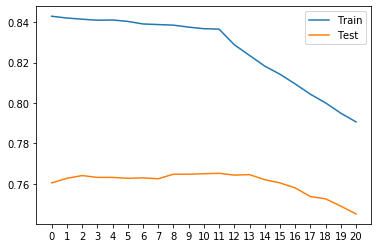

In [249]:
print("Max alpha at", test_f1.index(max(test_f1)),".", "Alpha value :",alpha[test_f1.index(max(test_f1))])
plt.plot(range(len(alpha)), result)
plt.xticks(range(len(alpha)))
plt.legend(["Train", "Test"])
plt.show()

### Best Bayes Model Confusion Matrix

In [263]:
mnb_modelfin = make_pipeline(tv1, MultinomialNB(alpha=0.1))
mnb_modelfin.fit(train.text, train.airline_sentiment)
train_preds = mnb_modelfin.predict(train.text)
train_f1 = f1_score(train.airline_sentiment, train_preds, average='micro')
test_preds = mnb_modelfin.predict(test.text)
test_f1 = f1_score(test.airline_sentiment, test_preds, average='micro')

In [264]:
def plot_confusion_matrix(preds, labels):
  class_labels = np.unique(train.airline_sentiment)
  class_size = len(class_labels)
  cnf_mat = confusion_matrix(labels, preds, class_labels)                            #Computes confusion_matrix
  cnf_mat = cnf_mat.astype('float') / (cnf_mat.sum(axis=1)[:, np.newaxis]+1)
  plt.imshow(cnf_mat, interpolation='nearest', cmap=plt.cm.Blues)
  #plt.xticks(np.arange(class_size), np.arange(1, class_size + 1), class_labels)
  plt.xticks(np.arange(class_size), labels=class_labels, rotation='vertical')
  plt.yticks(np.arange(class_size), labels=class_labels)
  #plt.yticks(np.arange(class_size), np.arange(1, class_size + 1), class_labels)
  plt.title('Confusion matrix of the classifier')
  plt.xlabel('True Label')
  plt.ylabel('Predicted Label')
  plt.title('Confusion Matrix')
  plt.colorbar()
  plt.show()

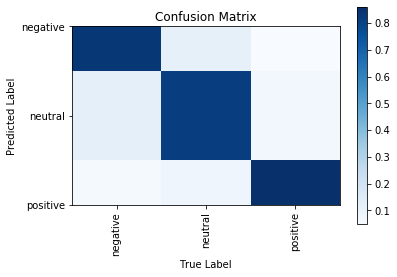

Train F1 score: 0.8365968278832975


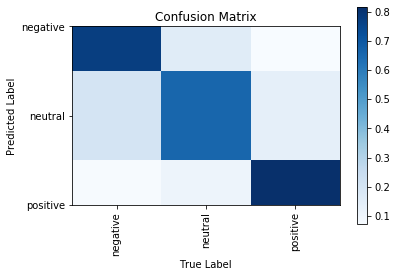

Test F1 score: 0.7652507907817442


In [265]:
plot_confusion_matrix(train.airline_sentiment, train_preds)
print("Train F1 score:", train_f1)
plot_confusion_matrix(test.airline_sentiment, test_preds)
print("Test F1 score:", test_f1)

# Positive vs Negative Sentiment Categories Using LDA

In [423]:
pos = tweets[tweets.airline_sentiment == 'positive']
neg = tweets[tweets.airline_sentiment == 'negative']
neu = tweets[tweets.airline_sentiment == 'neutral']

### negative tweets categories - overall

In [9]:
text = neg.text.dropna()
text = text.to_string().lower()
print("There are {} wor ds in the combination of all review.".format(len(text)))

There are 541501 wor ds in the combination of all review.


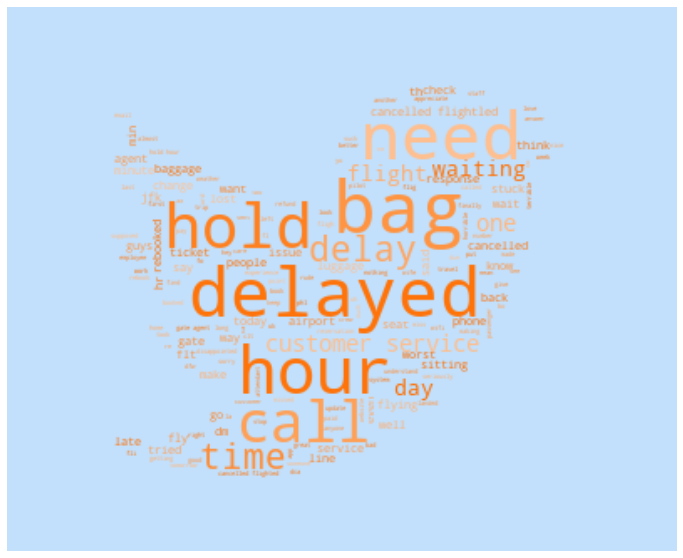

In [34]:
np.random.seed(123)
char_mask = np.array(Image.open("/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/tweey.png"))


def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
def grey_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(26,100%%, %d%%)" % np.random.randint(50,80))

    
transformed_mask = np.ndarray((char_mask.shape[0],char_mask.shape[1]), np.int32)
for i in range(len(char_mask)):
    transformed_mask[i] = list(map(transform_format, char_mask[i]))
    
    
stopwords = set(STOPWORDS)
stopwords.update(["american", "air","airline","thank","united","us","airways","virgin","america","jetblue",
                 "usairway","usairways","flight","americanair","southwestair","southwestairlines",
                 "southwestairway","southwestairways","virginamerica","really","will","going","thanks","thankyou",
                 "please","got","let","take","help","already","never","now","told","guy","new","sure","still","amp",
                 "plane","tell","ye","trying","yes"])

textwc = WordCloud(stopwords=stopwords,mask=transformed_mask, max_words=200,random_state=1,background_color="#c2e0fc").generate(text)
plt.figure(figsize=[20,10])
plt.imshow(textwc.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.savefig('/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/wcneg.png',transparent=True)
plt.show()

### Analysis with External Source

In [146]:
warnings.simplefilter('ignore')

ual = pd.read_csv("/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/UALstockprice.csv")
ual['Date'] = [pd.to_datetime(i).date().strftime('%y-%m-%d') for i in ual.Date]

neg['tweet_dttm']=pd.to_datetime(neg['tweet_created'])
neg['tweets_date'] =[i.strftime('%y-%m-%d') for i in neg.tweet_dttm]

df=neg.groupby(['tweets_date']).size().reset_index(name='negative_tweets_total')
df=df.sort_values(by=['tweets_date']).reset_index(drop=True)
mergedf = df.merge(ual, how = 'inner', left_on = 'tweets_date', right_on = 'Date')

In [148]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=mergedf.tweets_date, y=mergedf.negative_tweets_total, name="Total Negative Tweets",mode='lines+markers',line=dict(color="#3f5994",width=2)),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=mergedf.tweets_date, y=mergedf.Close, name="Closing Stock Price",mode='lines+markers',line=dict(color='#f49c6c',width=4, dash='dot')),
    secondary_y=True,
)

# Add figure title
fig.update_layout(
    title_text="<b> Daily Total Negative Sentiment Tweets vs Closing Stock Price</b> "
)

# Set x-axis title
fig.update_xaxes(title_text="Date")

# Set y-axes titles
fig.update_yaxes(title_text="<b>Total Negative Tweets</b>", secondary_y=False)
fig.update_yaxes(title_text="<b>Closing Stock Price</b> ", secondary_y=True)

fig.show()

### positive tweets categories - overall

In [26]:
text1 = pos.text.dropna()
text1 = text1.to_string().lower()
print("There are {} wor ds in the combination of all review.".format(len(text1)))

There are 139416 wor ds in the combination of all review.


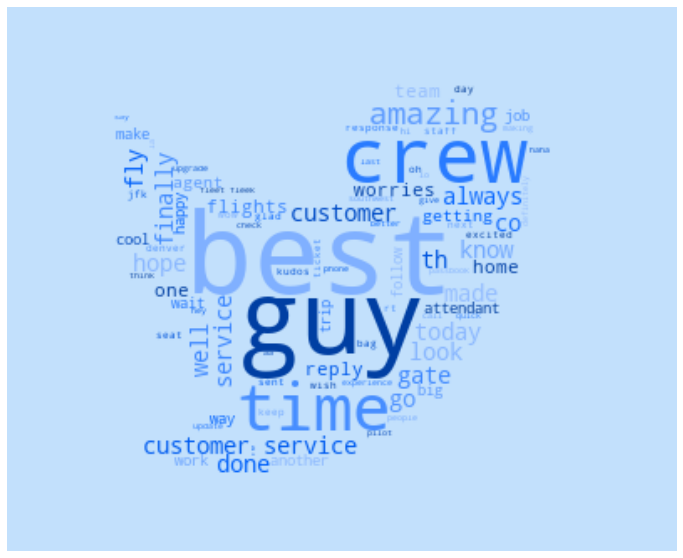

In [33]:
np.random.seed(123)
char_mask = np.array(Image.open("/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/tweey.png"))


def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
def blue_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(217,100%%, %d%%)" % np.random.randint(30,80))

    
transformed_mask = np.ndarray((char_mask.shape[0],char_mask.shape[1]), np.int32)
for i in range(len(char_mask)):
    transformed_mask[i] = list(map(transform_format, char_mask[i]))
    
    
stopwords = set(STOPWORDS)
stopwords.update(["american", "air","airline","thank","united","us","airways","virgin","america","jetblue",
                 "usairway","usairways","flight","americanair","southwestair","southwestairlines",
                 "southwestairway","southwestairways","virginamerica","really","will","going","thanks","thankyou",
                 "please","got","let","take","help","already","never","now","told","guy","new","sure","still","amp",
                 "plane","tell","ye","trying","yes","guy","much","appreciate", "thx","back","ok","good",
                 "flying","love","great","awesome","see","nice","alway"])

textwc = WordCloud(stopwords=stopwords,mask=transformed_mask, max_words=200,random_state=1,\
                   background_color="#c2e0fc").generate(text1)
plt.figure(figsize=[20,10])
plt.imshow(textwc.recolor(color_func=blue_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.savefig('/Users/jenniferwu/Desktop/MSBA/Spring 2020/NLP/final project/wcpos.png',transparent=True)
plt.show()

# LDA Model

<u>References:</u>
- https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05
- http://blog.echen.me/2012/03/20/infinite-mixture-models-with-nonparametric-bayes-and-the-dirichlet-process/
- https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
- https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
- https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
- https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/
- https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

Topic Models, in a nutshell, are a type of statistical language models used for uncovering hidden structure in a collection of texts. In a practical and more intuitively, you can think of it as a task of:

1. Dimensionality Reduction <br>
where rather than representing a text T in its feature space as {Word_i: count(Word_i, T) for Word_i in Vocabulary}, you can represent it in a topic space as {Topic_i: Weight(Topic_i, T) for Topic_i in Topics}.
2. Unsupervised Learning <br>
where it can be compared to clustering, as in the case of clustering, the number of topics, like the number of clusters, is an output parameter. By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight.
3. Tagging <br>
abstract “topics” that occur in a collection of documents that best represents the information in them.

We can describe the generative process of LDA as, given the M number of documents, N number of words, and prior K number of topics, the model trains to output:
psi, the distribution of words for each topic K
phi, the distribution of topics for each document i



### Parameters of LDA
* **Alpha** parameter is Dirichlet prior concentration parameter that represents document-topic density — with a higher alpha, documents are assumed to be made up of more topics and result in more specific topic distribution per document.
* **Beta** parameter is the same prior concentration parameter that represents topic-word density — with high beta, topics are assumed to made of up most of the words and result in a more specific word distribution per topic.

# LDA Model to Find Topics for Negative Reviews

In [473]:
#preprocess data
def preprocess(text):
    stopwords = set(STOPWORDS)
    stopwords.update(["american", "air","airline","thank","united","us","airways","virgin","america","jetblue",
                     "usairway","usairways","flight","americanair","southwestair","southwestairlines",
                     "southwestairway","southwestairways","virginamerica","really","will","going","thanks","thankyou",
                     "please","got","let","take","help","already","never","now","told","guy","new","sure","still","amp",
                     "plane","tell","ye","trying","yes","guy","much","appreciate", "thx","back","ok","good",
                     "flying","love","great","awesome","see","nice","alway","httptcojwl26g6lrw","dontflythem",
                     "nogearnotraining","seriously","didnt","coudnt","cant","wont","dont","wat","buffaloniagara",
                     "woulda","people","try","youve","youd","yours","flightled","tomorrow","today","wat",
                     "flightr","flight","need","hours","nooooo","like","doesnt",
                     "wasnt","suppose","want","understand","come"])
    r = re.compile(r'(?<=\@)(\w+)') #remove words after tags --> usually twitter account
    ra = re.compile(r'(?<=\#)(\w+)') #remove words after hashtags
    ro = re.compile(r'(flt\d*)') #remove words after flight number
    names = r.findall(text.lower())
    hashtag = ra.findall(text.lower())
    flight = ro.findall(text.lower())
    lmtzr = WordNetLemmatizer()
    def stem_tokens(tokens, lemmatize):
        lemmatized = []
        for item in tokens:
            lemmatized.append(lmtzr.lemmatize(item,'v'))
        return lemmatized
    def deEmojify(inputString):
        return inputString.encode('ascii', 'ignore').decode('ascii')
    
    text = deEmojify(text)
    soup = BeautifulSoup(text)
    text = soup.get_text()
    text = "".join([ch.lower() for ch in text if ch not in string.punctuation])
    tokens = nltk.word_tokenize(text)
    tokens = [ch for ch in tokens if len(ch)>3] #remove words with character length below 2
    tokens = [ch for ch in tokens if len(ch)<=15] #remove words with character length above 15 
    lemm = stem_tokens(tokens, lmtzr)
    lemstop = [i for i in lemm if i not in stopwords]
    lemstopcl = [i for i in lemstop if i not in names]
    lemstopcl = [i for i in lemstopcl if i not in hashtag]
    lemstopcl = [i for i in lemstopcl if i not in flight]
    lemstopcl = [i for i in lemstopcl if not i.isdigit()]
    return lemstopcl

In [474]:
#testing the tokenizer
text = """@Jenny @Joe and @Susan we are all very dissapointed in your service 
            for flt15539 560948 #notdoingthisanymore #dontflythem"""
preprocess(text)

['dissapointed', 'service']

In [476]:
neg['token']=neg.text.map(preprocess)
processed_docs=neg['token']
id2word = gensim.corpora.Dictionary(processed_docs)
corpus = [id2word.doc2bow(text) for text in processed_docs]

In [477]:
def compute_coherence_values(dictionary, corpus, texts, start, stop):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, 
                                                num_topics=num_topics,
                                                id2word=id2word,
                                               random_state=100,
                                               alpha='auto',
                                               per_word_topics=True)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [481]:
start=4
stop=10
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=processed_docs,
                                                        start=start, 
                                                        stop=stop)

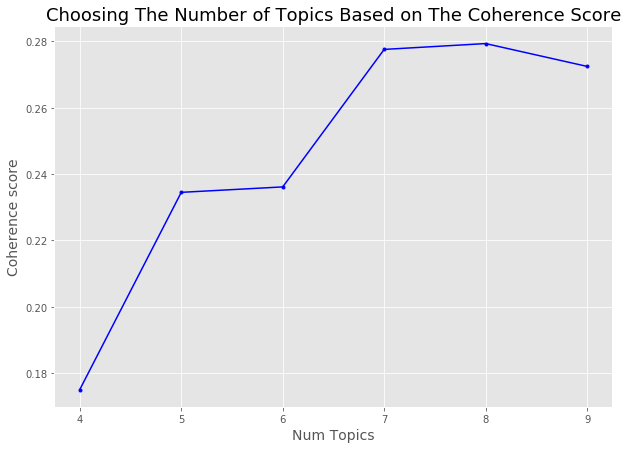

In [482]:
x = range(start, stop)
plt.figure(figsize=(10,7))
plt.style.use('ggplot')
plt.plot(x, coherence_values, color = "blue",marker=".")
plt.xlabel("Num Topics", size=14)
plt.ylabel("Coherence score", size=14)
plt.title('Choosing The Number of Topics Based on The Coherence Score',size=18)
plt.show()

### Choosing 8 as the number of topics for negative reviews

In [483]:
# Create Dictionary
id2word = gensim.corpora.Dictionary(processed_docs)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in processed_docs]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=8, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='auto',
                                           iterations=100,
                                           per_word_topics=True)
doc_lda = lda_model[corpus]

In [496]:
from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.040*"service" + 0.029*"customer" + 0.029*"delay" + 0.028*"late" + '
  '0.021*"gate" + 0.019*"rebooked" + 0.017*"line" + 0.014*"issue" + '
  '0.010*"info" + 0.009*"experience"'),
 (1,
  '0.219*"cancel" + 0.061*"agent" + 0.036*"stick" + 0.036*"crew" + '
  '0.035*"home" + 0.033*"email" + 0.032*"response" + 0.022*"days" + '
  '0.020*"arrive" + 0.018*"fly"'),
 (2,
  '0.078*"wait" + 0.063*"phone" + 0.039*"hour" + 0.037*"ticket" + '
  '0.032*"airport" + 0.030*"book" + 0.028*"hang" + 0.028*"bag" + '
  '0.027*"change" + 0.026*"miss"'),
 (3,
  '0.104*"work" + 0.085*"know" + 0.048*"talk" + 0.042*"right" + 0.039*"drive" '
  '+ 0.033*"look" + 0.033*"suck" + 0.032*"assistance" + 0.030*"hotel" + '
  '0.028*"happen"'),
 (4,
  '0.136*"time" + 0.110*"weather" + 0.056*"thats" + 0.040*"rebook" + '
  '0.040*"available" + 0.036*"sit" + 0.026*"website" + 0.026*"tonight" + '
  '0.025*"doesnt" + 0.020*"passenger"'),
 (5,
  '0.125*"luggage" + 0.072*"baggage" + 0.052*"think" + 0.041*"food" + '
  '0.039

In [486]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=processed_docs, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.731965526903773

Coherence Score:  0.42812638156254745


In [492]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.342308 -0.190805       1        1  37.700432
2     -0.146075  0.355276       2        1  20.873842
1      0.055559 -0.028647       3        1  11.865224
6      0.080356 -0.026175       4        1   7.795342
4      0.074389 -0.024178       5        1   7.496064
3      0.093091 -0.028897       6        1   5.523101
7      0.094811 -0.028452       7        1   4.890841
5      0.090178 -0.028123       8        1   3.855152, topic_info=     Category         Freq           Term        Total  loglift  logprob
113   Default  1461.000000         cancel  1461.000000  30.0000  30.0000
90    Default   674.000000           hold   674.000000  29.0000  29.0000
22    Default   573.000000           time   573.000000  28.0000  28.0000
178   Default   915.000000           wait   915.000000  27.0000  27.0000
214   Default   463.000000        weather   463.000000  26.0000  26.0000
...       ...          ...            ...          ...      ...      ...
675    Topic8     2.162667        medical    30.187817   0.6197  -6.9115
233    Topic8     2.346298           ring    36.323524   0.5161  -6.8300
6455   Topic8     3.604295  understaffing   109.211098  -0.1554  -6.4008
6497   Topic8     2.273490          taste    37.673634   0.4481  -6.8616
6537   Topic8     2.431812           hoop    51.935158   0.1944  -6.7942

[298 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
6568      1  0.248548    3231dtw
6568      2  0.248548    3231dtw
6568      3  0.248548    3231dtw
6443      1  0.230716     aa2402
6443      2  0.115358     aa2402
...     ...       ...        ...
290       2  0.993043      worst
292       2  0.996097      wrong
1137      4  0.786797       yell
190       1  0.995755  yesterday
112       1  0.997135      youre

[413 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 2, 7, 5, 4, 8, 6])